In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np


In [6]:
df = pd.read_csv("../data/data.csv")

In [7]:
df.shape

(4407, 3)

In [8]:
df.head

<bound method NDFrame.head of       ir_L  ir_R  degree
0      6.2  23.3    7.63
1      3.8  40.0    7.58
2      3.0  72.8    7.56
3      3.0  63.1    7.57
4      3.0  69.3    7.56
...    ...   ...     ...
4402  31.2   8.2   37.92
4403  31.4   8.6   37.85
4404  31.7   9.1   37.96
4405  31.4   9.5   38.24
4406  31.1   9.6   38.06

[4407 rows x 3 columns]>

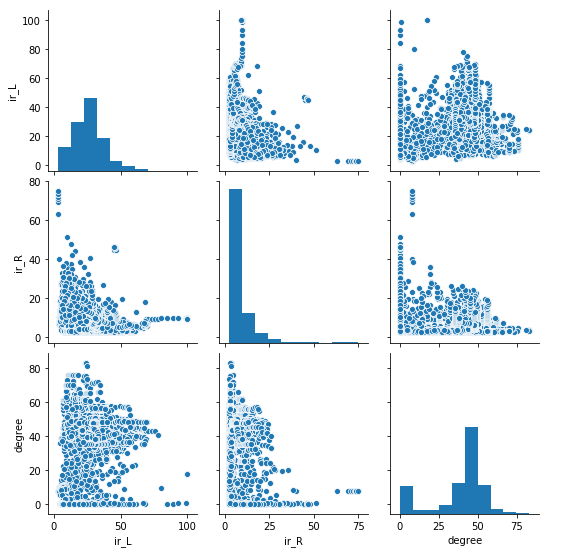

In [9]:
sns.pairplot(df, diag_kind='hist')

plt.show()

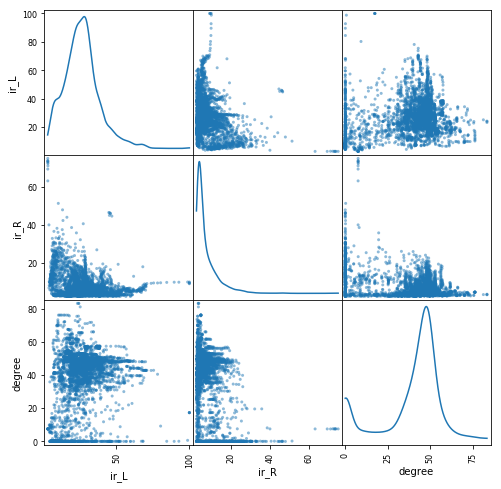

In [10]:
scatter_matrix(df, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()

# Normalization

In [ ]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(df)
df_n = pd.DataFrame(scaler.transform(df),columns=['ir_L', 'ir_R', 'degree'])

In [ ]:
df_n

# Split data

In [11]:
# Original Data
df_inputs = df.loc[:,['ir_L', 'ir_R']]
df_outputs = df.loc[:,['degree']]

# Normalized Data
# df_inputs = df_n.loc[:,['ir_L', 'ir_R']]
# df_outputs = df_n.loc[:,['degree']]

inputs = np.array(df_inputs)
outputs = np.array(df_outputs)

In [12]:
num_data = len(inputs)
TRAIN_SPLIT = int(0.6 * num_data)
TEST_SPLIT = int(0.2 * num_data + TRAIN_SPLIT)

In [13]:
inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

# Multiple Linear Regression

In [14]:
from sklearn.linear_model import LinearRegression
mlr = LinearRegression()
mlr.fit(inputs_train, outputs_train)

LinearRegression()

In [15]:
# The coefficients
print('Coefficients: \n', mlr.coef_)

# mean square error
print("RSS: %.2f" % np.mean((mlr.predict(inputs_test) - outputs_test) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % mlr.score(inputs_test, outputs_test))

Coefficients: 
 [[ 0.27028608 -1.08837148]]
RSS: 241.77
Variance score: 0.27


In [16]:
outputs_predict = mlr.predict(inputs_test)

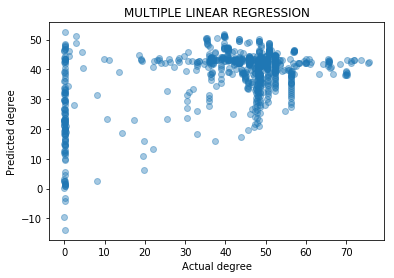

In [17]:
plt.scatter(outputs_test, outputs_predict, alpha=0.4)
plt.xlabel("Actual degree")
plt.ylabel("Predicted degree")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

# DNN

In [18]:
import tensorflow as tf

In [30]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape = inputs_train.shape[1]))
model.add(tf.keras.layers.Dense(100, activation='relu'))
# model.add(tf.keras.layers.Dropout(rate=.2))
# model.add(tf.keras.layers.Dense(50, activation='relu'))
# model.add(tf.keras.layers.Dropout(rate=.2))

model.add(tf.keras.layers.Dense(1, activation='relu'))



# model.compile(optimizer='adam', loss='mae', metrics=['mae']) # mse / mae
model.compile(optimizer='adam', loss='mae', metrics=['mae']) # mse / mae
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(inputs_train, outputs_train, epochs=1, batch_size=1, validation_data=(inputs_validate, outputs_validate))

Train on 2644 samples, validate on 882 samples
2644/2644 [==============================] - 10s 4ms/sample - loss: 13.2702 - mean_absolute_error: 13.2702 - val_loss: 11.4939 - val_mean_absolute_error: 11.4939


In [33]:
outputs_predict = model.predict(inputs_test)

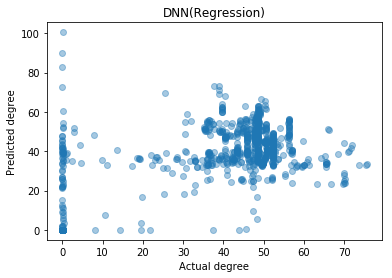

In [34]:
plt.scatter(outputs_test, outputs_predict, alpha=0.4)
plt.xlabel("Actual degree")
plt.ylabel("Predicted degree")
plt.title("DNN(Regression)")
plt.show()

# Feature 추가(mot_L, mot_R)

In [35]:
def chdeg(degree_original):
    degree = ((degree_original - 50)*1.5)//1
    if degree <= 0:
        left = 25
        right = 25 + abs(degree)
    else:
        left = 25 - abs(degree)
        right = 25
    return left, right

left = []
right = []
for i in range(len(df)):
    left.append(chdeg(df['degree'][i])[0])
    right.append(chdeg(df['degree'][i])[1])
    
df['mot_L'] = left
df['mot_R'] = right

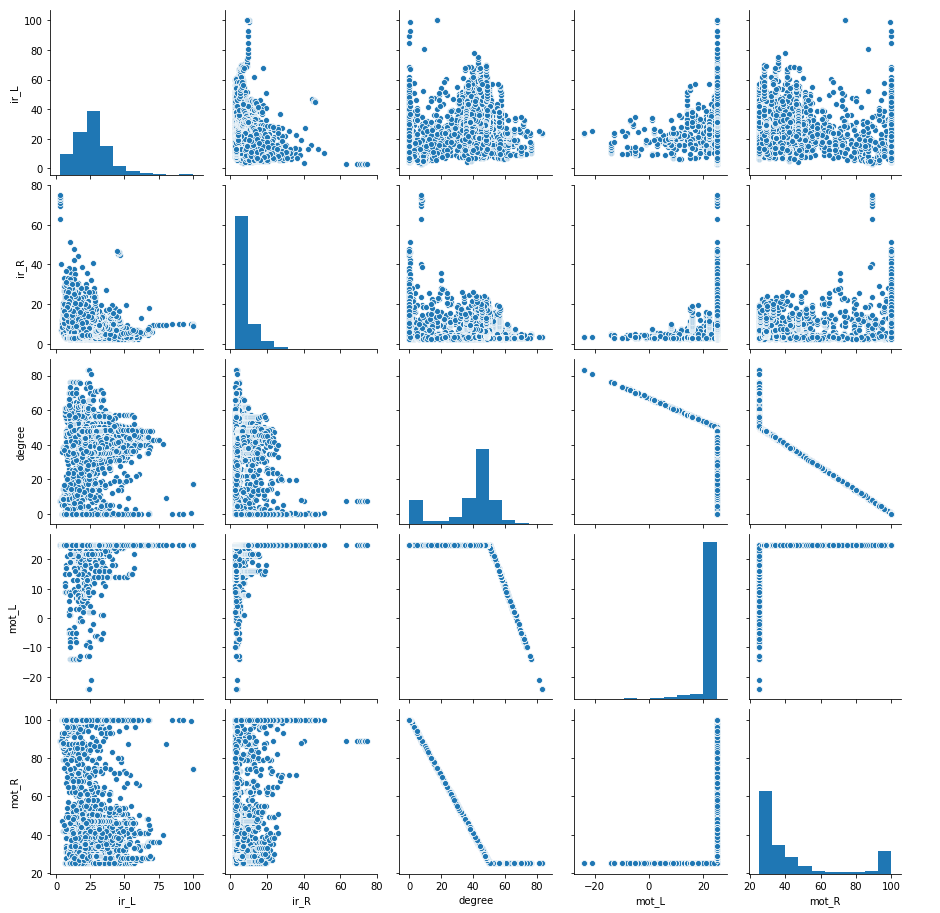

In [36]:
sns.pairplot(df, diag_kind='hist')

plt.show()

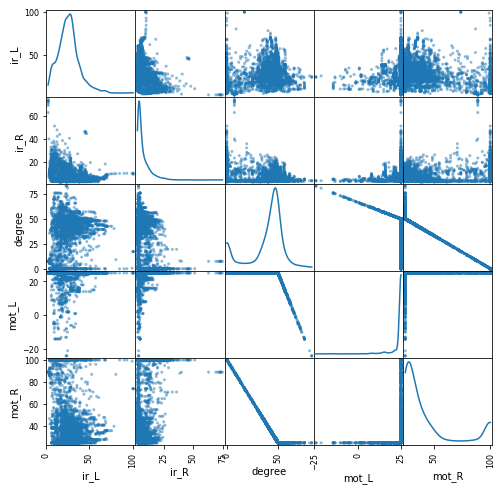

In [37]:
scatter_matrix(df, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()

# Feature 추가(ir distance 차이, 비율)

### ir 좌우 차이

In [38]:
df['ir_R-L'] = df['ir_R'] - df['ir_L']
df['ir_L/R'] = df['ir_L'] / df['ir_R'] 
df

,ir_L,ir_R,degree,mot_L,mot_R,ir_R-L,ir_L/R
0,6.2,23.3,7.63,25.0,89.0,17.1,0.266094
1,3.8,40.0,7.58,25.0,89.0,36.2,0.095000
2,3.0,72.8,7.56,25.0,89.0,69.8,0.041209
3,3.0,63.1,7.57,25.0,89.0,60.1,0.047544
4,3.0,69.3,7.56,25.0,89.0,66.3,0.043290
...,...,...,...,...,...,...,...
4402,31.2,8.2,37.92,25.0,44.0,-23.0,3.804878
4403,31.4,8.6,37.85,25.0,44.0,-22.8,3.651163
4404,31.7,9.1,37.96,25.0,44.0,-22.6,3.483516
4405,31.4,9.5,38.24,25.0,43.0,-21.9,3.305263


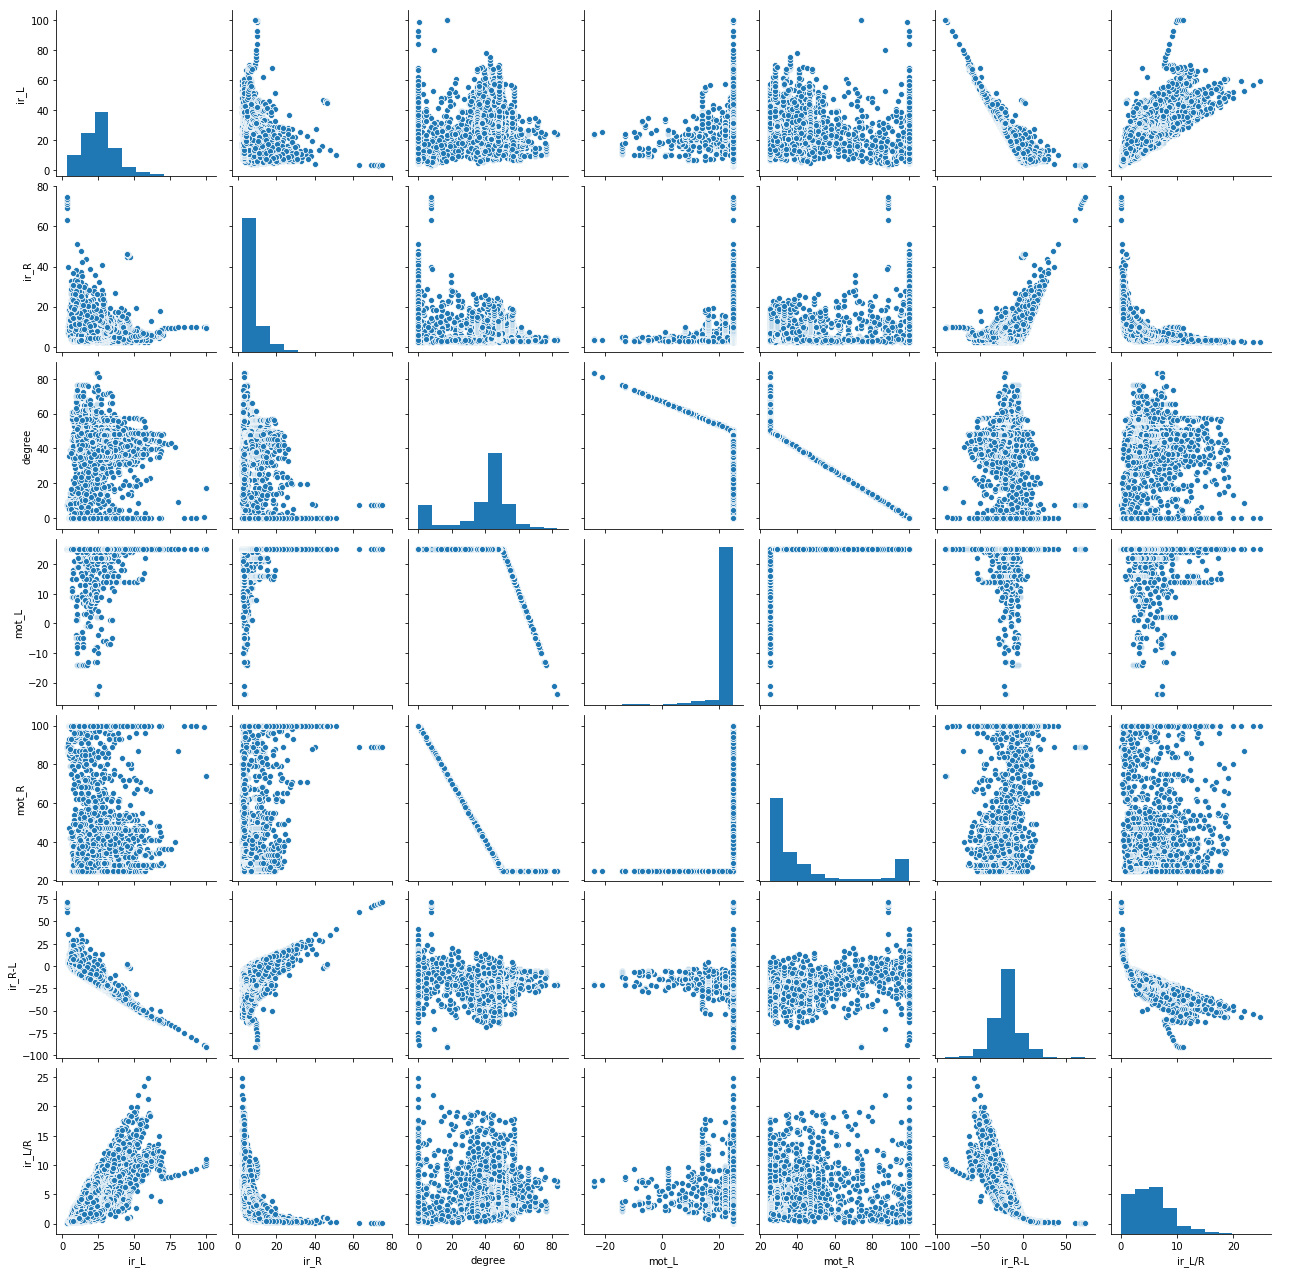

In [39]:
sns.pairplot(df, diag_kind='hist')

plt.show()

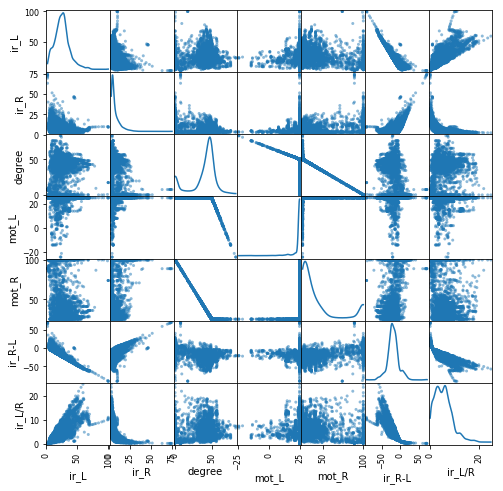

In [40]:
scatter_matrix(df, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()

# Except degree under 10 over 90 data

In [ ]:
df.sort_values(by=['degree'])

In [ ]:
df_s = df.loc[(10 < df['degree']) & (df['degree'] < 90), : ]

In [ ]:
sns.pairplot(df_s, diag_kind='hist')

plt.show()

In [ ]:
scatter_matrix(df_s, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()

# exclude degree over 50

In [ ]:
df_d = df.loc[df['degree'] < 50, : ]
df_d

In [ ]:
sns.pairplot(df_d, diag_kind='hist')

plt.show()

In [ ]:
scatter_matrix(df_d, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()

# Time stamp 설정

In [41]:
# Time Stamp를 지정하여 그 안의 값들에 대해 대표값으로 데이터를 구성
# 대표값은 평균(averave), 중앙값(median), 최빈값(mode) 중 평균값과 중앙값을 우선적으로 테스트한다.

In [42]:
df

,ir_L,ir_R,degree,mot_L,mot_R,ir_R-L,ir_L/R
0,6.2,23.3,7.63,25.0,89.0,17.1,0.266094
1,3.8,40.0,7.58,25.0,89.0,36.2,0.095000
2,3.0,72.8,7.56,25.0,89.0,69.8,0.041209
3,3.0,63.1,7.57,25.0,89.0,60.1,0.047544
4,3.0,69.3,7.56,25.0,89.0,66.3,0.043290
...,...,...,...,...,...,...,...
4402,31.2,8.2,37.92,25.0,44.0,-23.0,3.804878
4403,31.4,8.6,37.85,25.0,44.0,-22.8,3.651163
4404,31.7,9.1,37.96,25.0,44.0,-22.6,3.483516
4405,31.4,9.5,38.24,25.0,43.0,-21.9,3.305263


In [43]:
frame = 20
length = len(df)
df_frame = pd.DataFrame(columns=['ir_L', 'ir_R', 'degree', 'mot_L', 'mot_R', 'ir_R-L', 'ir_L/R'])
ir_L, ir_R, degree, mot_L, mot_R, ir_RL, ir_LR = [], [], [], [], [], [], []

for i in range(length//frame):
    a = i*frame
    b = (i+1)*frame
    ir_L.append(np.median(df['ir_L'][a:b]))
    ir_R.append(np.median(df['ir_R'][a:b]))
    degree.append(np.median(df['degree'][a:b]))
    mot_L.append(np.median(df['mot_L'][a:b]))
    mot_R.append(np.median(df['mot_R'][a:b]))
    ir_RL.append(np.median(df['ir_R-L'][a:b]))
    ir_LR.append(np.median(df['ir_L/R'][a:b]))
df_frame['ir_L'] = ir_L
df_frame['ir_R'] = ir_R
df_frame['degree'] = degree
df_frame['mot_L'] = mot_L
df_frame['mot_R'] = mot_R
df_frame['ir_R-L'] = ir_RL
df_frame['ir_L/R'] = ir_LR

In [44]:
df_frame

,ir_L,ir_R,degree,mot_L,mot_R,ir_R-L,ir_L/R
0,5.00,31.65,7.645,25.0,89.0,26.65,0.180547
1,18.85,2.80,46.860,25.0,30.5,-15.95,6.660714
2,8.50,3.40,55.230,17.5,25.0,-5.30,2.658847
3,15.75,4.05,50.730,24.0,25.0,-11.60,3.879801
4,19.45,5.30,50.720,24.0,25.0,-13.60,3.522222
...,...,...,...,...,...,...,...
215,50.30,5.30,48.490,25.0,28.0,-45.15,9.140757
216,28.25,11.40,35.395,25.0,47.0,-16.85,2.479680
217,21.00,4.85,2.525,25.0,97.0,-16.45,4.554377
218,20.85,4.20,47.920,25.0,29.0,-17.15,5.521337


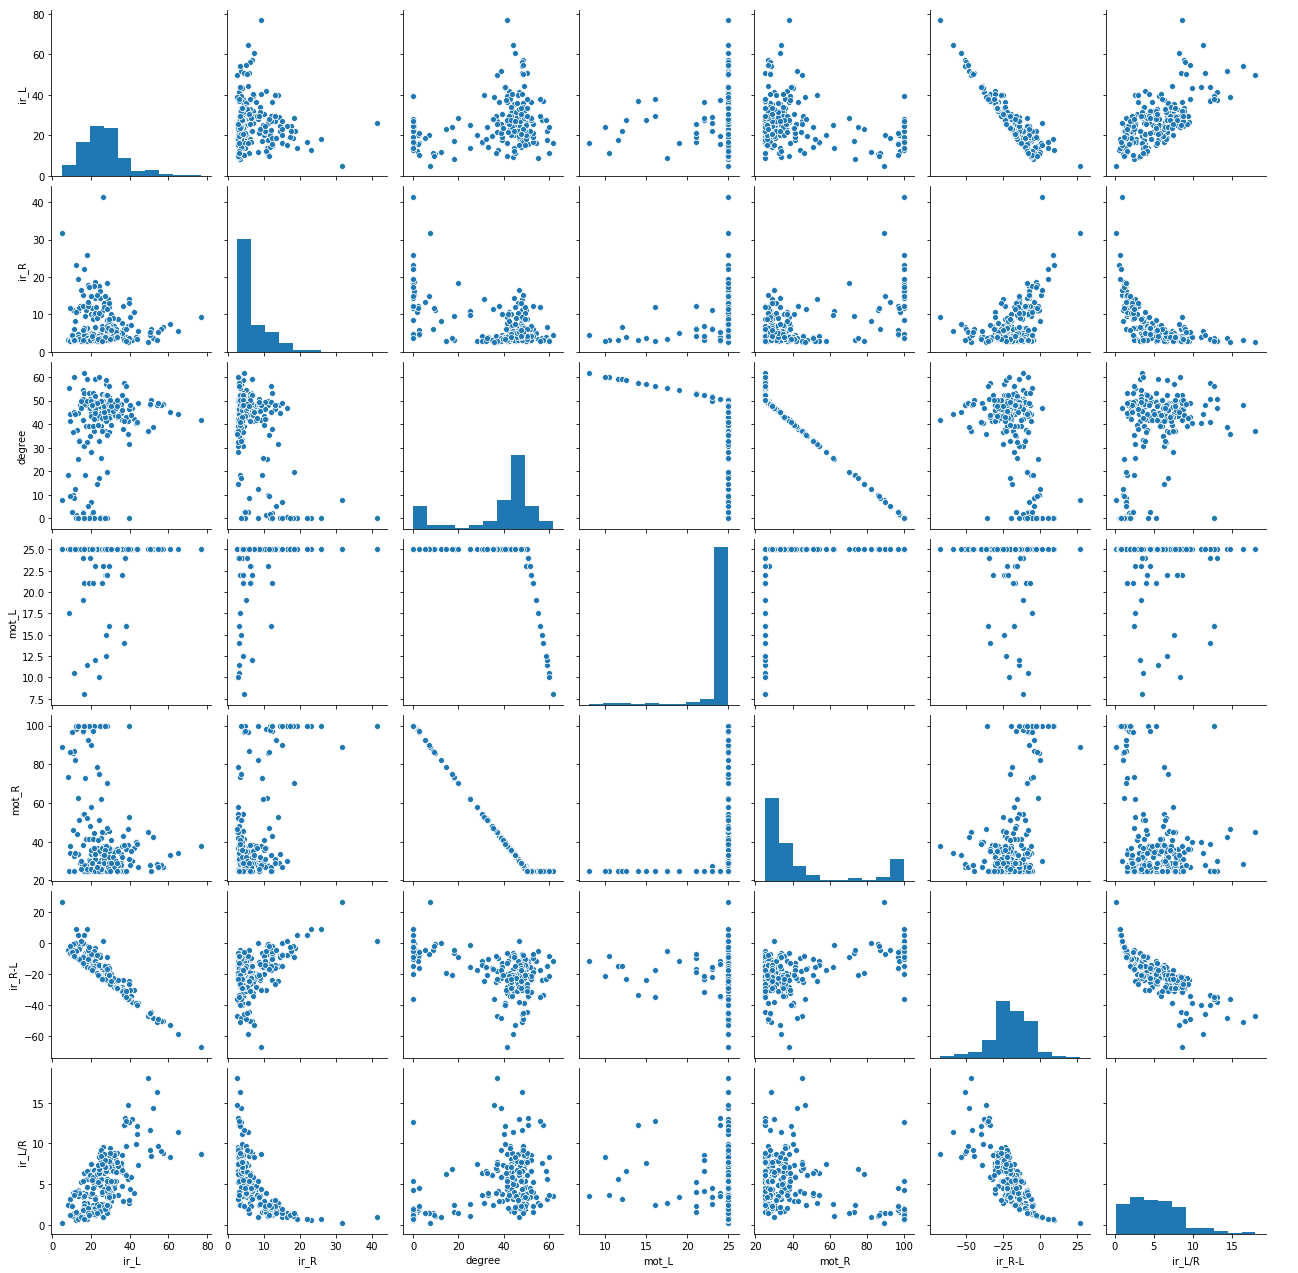

In [45]:
sns.pairplot(df_frame, diag_kind='hist')

plt.show()

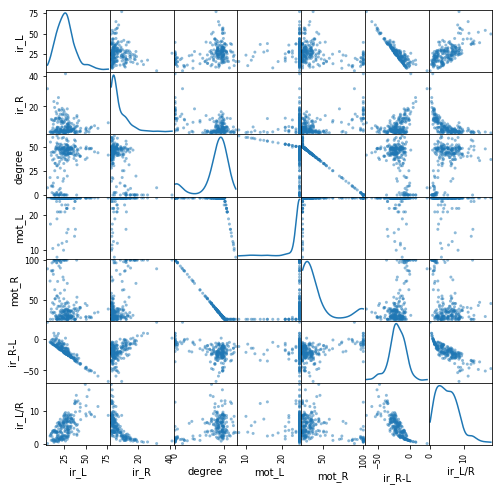

In [46]:
scatter_matrix(df_frame, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()